# OT2 - Face Detection

In [13]:
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
import torchvision.transforms as transforms

from torchsampler import ImbalancedDatasetSampler

from tqdm import tqdm

# Loader

In [7]:
train_dir = './train_images'
test_dir = './test_images'

transform = transforms.Compose(
    [transforms.Grayscale(), 
     transforms.ToTensor(), 
     transforms.Normalize(mean=(0,),std=(1,))])

train_data = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_data = torchvision.datasets.ImageFolder(test_dir, transform=transform)

valid_size = 0.2 # 20% used for validation
batch_size = 32 # 32 images per batch, after 21 images, back-propagate

num_train = len(train_data)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]

train_sampler = ImbalancedDatasetSampler(train_data, train_new_idx)
valid_sampler = ImbalancedDatasetSampler(train_data, valid_idx)

#train_sampler = SubsetRandomSampler(train_new_idx)
#valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=1)
classes = ('noface','face')

# Neural Network

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(64 * 6 * 6, 1000)
        self.fc2 = nn.Linear(1000, 2)
        self.softmax = nn.LogSoftmax(1)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x)) # Reshape tensor, -1 specifies flexible value
        x = self.drop_out(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

# Helpers

In [39]:
def show_image(images):
    image = torchvision.utils.make_grid(images, nrow=15)
    image = image / 2 + 0.5
    npimg = image.numpy()
    
    fig, ax = plt.subplots(figsize=(30, 30))
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

# Hyper-Parameters

In [27]:
n_epochs = 5
cv_folds = 1

# Learning and Cross Validation

== Iteration 0 ==


Epoch 1 - Validating 	: 100%|██████████| 574/574 [00:05<00:00, 100.32it/s]


train_loss: 0.14325 	 train_acc: 94.51%
valid_loss: 0.05705 	 valid_acc: 98.11%


Testing : 100%|██████████| 239/239 [00:02<00:00, 100.70it/s]


test_loss: 0.26032 	 test_acc: 93.17%


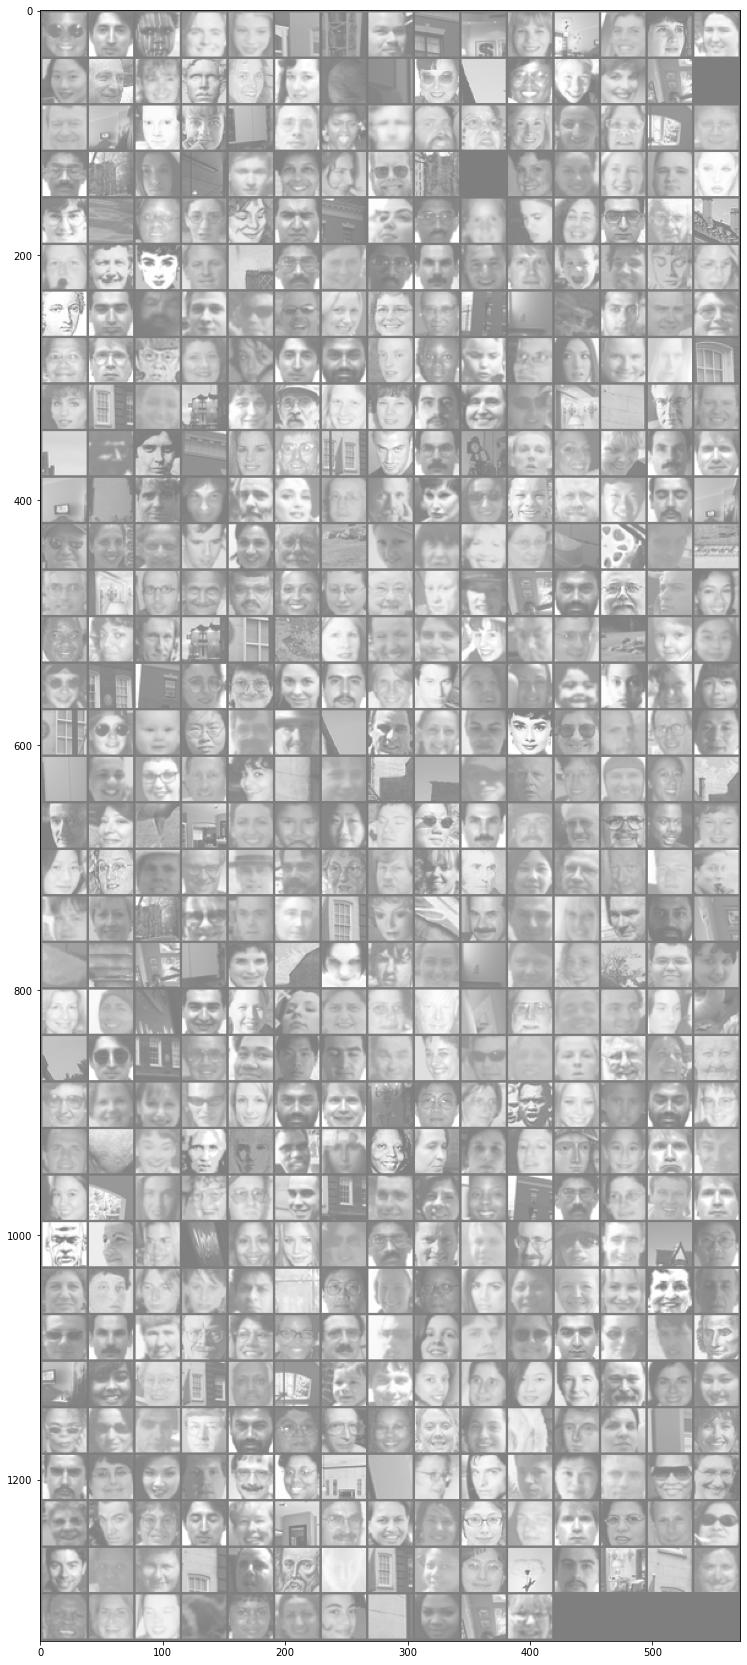

In [40]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = None

criterion = nn.CrossEntropyLoss() # Loss function

for k in range(cv_folds):
    print(f"== Iteration {k} ==")
    time.sleep(0.5)
    
    net = Net().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001) # Updates weights
    
    for epoch in range(1, n_epochs+1):
        train_loss_cumu, train_acc_cumu, train_total = 0, 0, 0
        
        # Training loop
        net.train()
        for data, target in tqdm(train_loader, desc=f"Epoch {epoch} - Training \t: "):
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            # Add to cumulated loss
            train_loss_cumu += loss.item()
            
            # Add to cumulated correct predictions
            _, predicted = torch.max(output.data, 1)
            train_acc_cumu += (predicted == target).sum().item() 
            train_total += target.size(0)
            
        train_loss = train_loss_cumu / len(train_loader)
        train_acc = train_acc_cumu / train_total
    
        valid_loss_cumu, valid_acc_cumu, valid_total = 0, 0, 0
        
        # Validation loop
        net.eval()
        for data, target in tqdm(valid_loader, desc=f"Epoch {epoch} - Validating \t: "):
            output = net(data)
            loss = criterion(output, target)
            
            # Add to cumulated loss
            valid_loss_cumu += loss.item()
            
            # Add to cumulated correct predictions
            _, predicted = torch.max(output.data, 1)
            valid_acc_cumu += (predicted == target).sum().item()
            valid_total += target.size(0)
            
        valid_loss = valid_loss_cumu / len(valid_loader)
        valid_acc = valid_acc_cumu / valid_total
        
        print(f"train_loss: {train_loss:.5f} \t train_acc: {train_acc * 100:.2f}%")
        print(f"valid_loss: {valid_loss:.5f} \t valid_acc: {valid_acc * 100:.2f}%")
        time.sleep(0.5)
    
    test_loss_cumu, test_acc_cumu, test_total = 0, 0, 0
    false_pred = []
    # Testing loop
    for data, target in tqdm(test_loader, desc=f"Testing : "):
        output = net(data)
        loss = criterion(output, target)
        
        # Add to cumulated loss
        test_loss_cumu += loss.item()
        
        # Add to cumulated correct predictions
        _, predicted = torch.max(output.data, 1)
        test_acc_cumu += (predicted == target).sum().item()
        test_total += target.size(0)
        
        # Append false estimations
        false_index = torch.nonzero((predicted != target), as_tuple=True)[0].numpy()
        for i in false_index:
            false_pred.append(data[i])
    
    test_loss = test_loss_cumu / len(test_loader)
    test_acc = test_acc_cumu / test_total
    print(f"test_loss: {test_loss:.5f} \t test_acc: {test_acc * 100:.2f}%")
    
    show_image(false_pred)

# Detector

In [ ]:
class FaceDetector(object):
    def __init__(self, cnn):
        self.cnn = cnn
    
    # Method to draw box to delimit detected face
    def _draw(self):
    
    # Entry point, gets an image as input
    def detect(self, image):

In [ ]:
fd = FaceDetector(net)